<table style="border: none" align="left">
   <tr style="border: none">
      <th style="text-align: left;border: none"><font face="verdana" size="5" color="black"><b>Train and deploy a heart disease prediction model using XGBoost and IBM Watson Machine Learning APIs</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://github.com/pmservice/drug-selection/raw/master/images/heart_banner.png" width="600" alt="Icon"> </th>
   </tr>
</table>

This notebook demonstrates how to train a model using the XGBoost library to classify whether a person has heart disease or not. In addition to training, the notebook also explains how to persist a trained model to IBM Watson Machine Learning repository, and deploy the model as a REST service.  

In order to train and test the heart disease prediction model, you will be using an open source data set published in the University of California, Irvine (UCI) Machine Learning Repository. 

This notebook uses Python 3.5 runtime, XGBoost 0.6 and Scikit-Learn 0.17. 



## Notebook Tips

For those unfamiliar with using a notebook, please read this section. Otherwise, proceed to the next section.<br><br> 
A notebook consists of a series of cells. Cells consist of code or documentation (called markdown).<br>
Cells that are prefixed with an **In [ ]** consist of code. One's prefixed with an **Out** indicate displayed output which appear after executing the code. <br>
To execute a code cell you need to move the cursor into the cell, and then click on the Run icon in the toolbar at the top, <br>
or press the Shift-Enter keys. Once the cell has been executed a number will appear (e.g. **In [1]**)

## Learning goals

The learning goals of this notebook are:

-  Load a CSV file into Pandas DataFrame.
-  Prepare data for training and evaluation.
-  Create, train and evaluate a XGBoost model.
-  Visualize a decision trees used by the model.
-  Visualize the importance of features that were used to train the model.
-  Use cross validation to select optimal model hyperparameters based on a parameter grid
-  Persist a model in Watson Machine Learning repository using Python client library.
-  Deploy a model for online scoring using the Watson Machine Learning's REST APIs



## Table of contents
This notebook contains the following sections:

1.	[Setup](#setup)
2.	[Load and explore data](#load)
3.	[Create XGBoost model](#create)
4.	[Persist model](#persistence)
5.	[Deploy to the Cloud](#deploy)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you execute the sample code in this notebook, you must download the **Heart Disease Data Set** data in the Notebook's local filesystem

### Download Heart Disease Data Set  to Notebook's local filesystem
The Heart Disease Data Set is a freely available data set on the UCI Machine Learning Repository portal. The **Heart Disease Data Set** is hosted [here](http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data).



In order to download the data from UCI Machine Learning Repository, use the `wget` library. Use the following command to install the `wget` library: `!pip install wget` 

In [1]:
!pip install wget 

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190327153116-0000
KERNEL_ID = 5d788542-b39f-4a8d-bc5c-abbce6fc59a5
  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
pyspark 2.3.0 requires py4j==0.10.6, which is not installed.


Now, the code in the cell below downloads the data set and saves it in the local filesystem. The name of downloaded file containing the data will be displayed in the output of this cell.

In [2]:
import wget

link_to_data = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# make sure no duplicates
!rm processed.cleveland*.data

ClevelandDataSet = wget.download(link_to_data)

print(ClevelandDataSet)

rm: cannot remove 'processed.cleveland*.data': No such file or directory
processed.cleveland.data


The .csv file, **processed.cleveland.data**, that contains the heart disease data set is now availble on your local gpfs filesystem. 

The downloaded data set contains the following attributes pertaining to heart disease.

### Data set Details:
1. age - age in years
2. sex - sex(1 =  male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < 50% diameter narrowing; Value 1 = > 50% diameter narrowing)


<a id="load"></a>
## 2. Load and explore data

In this section you will load the data as a Pandas data frame and perform a basic exploration.


Load the data in the .csv file, **processed.cleveland.data**, into a Pandas data frame by running the code below. Note that the dataset does not contain header information so that is provided in the col_names variable. The first 5 lines will be displayed by using the .head() method. 

In [3]:
import pandas as pd

In [4]:
col_names = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

heart_data_df = pd.read_csv(ClevelandDataSet, sep=',', header=None, names=col_names, na_filter= True, na_values= {'ca': '?', 'thal': '?'})
heart_data_df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Let us see how many attributes and samples we have in this data set by using the .shape attribute. 

In [5]:
(samples, attributes) = heart_data_df.shape
print("No. of Sample data =", samples )
print("No. of Attributes  =", attributes)

No. of Sample data = 303
No. of Attributes  = 14


We have 303 rows of sample data with 14 columns of data per sample. 

We will now create a derived attribute that will serve as our target. The goal of the model is to predict whether a patient has a heart problem. The data set as currently constructed does not directly have this information. However, this information can be derived from the `num` attribute. The `num` column and its values pertain to the number of major vessels with more than 50% narrowing (values- 0,1,2,3 or 4) for the corresponding sample data. 

Therefore, the target column `diagnosed` can derived in the following way: 
- 'diagnosed' is '0' when 'num' = 0 , indicating normal heart functioning 
- 'diagnosed' is '1' when 'num' > 0 , indicating a heart problem.


In [6]:
heart_data_df['diagnosed'] = heart_data_df['num'].map(lambda d: 1 if d > 0 else 0)

Use pandas describe method to get dataset statistics

In [7]:
heart_data_df.describe()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosed
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000


We can see from the describe statistics (count row) that the "ca" field, and the "thai" field have missing values. This will be handled below. Now we will use IBM's pixiedust library to visualize the data. IBM has open sourced pixiedust. Pixiedust front-ends a number of visualization libraries and makes it easier to create visualizations with an interactive interface. Instead of coding, you can select different charts using the chart icon (second icon below) and then click on Options to select the variables to visualize. Please experiment with pixiedust to get a better understanding of the data characteristics and relationships. 


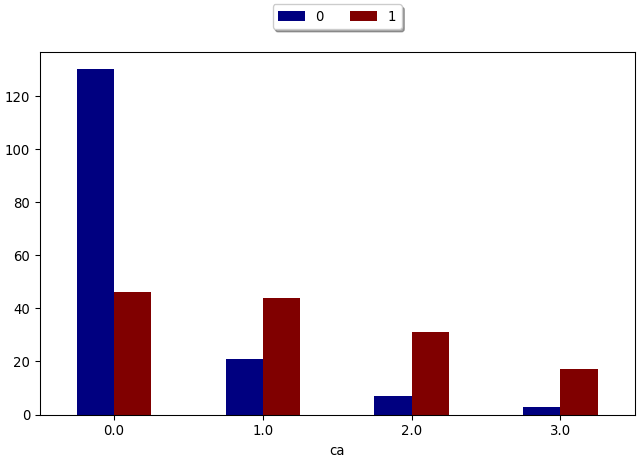

In [8]:
import pixiedust
display(heart_data_df)

<a id="create"></a>
## 3. Create an XGBoost model

In recent years, ensemble learning models took the lead and became popular among machine learning practitioners.

Ensemble learning model employs multiple machine learning algorithms to overcome the potential weaknesses of a single model. For example, if you are going to pick a destination for your next vacation, you probably ask your family and friends, read reviews and blog posts. Based on all the information you have gathered, you make your final decision.

This phenomenon is referred as the Wisdom of Crowds (WOC) in social sciences and it states that averaging the answers (prediction or probability) of a group will often result better than the answer of one of its members. The idea is that the collective knowledge of diverse and independent individuals will exceed the knowledge of any one of those individuals, helping to eliminate the noise.

XGBoost is an open source library for ensemble based algorithms. It can be used for classification, regression and ranking type of problems. XGBoost supports multiple languages, such as C++, Python, R, and Java. 

The Python library of XGBoost supports the following API interfaces to train and predict a model, also referred to as a `Booster`: 
- XGBoost's native APIs pertaining to the `xgboost` package, such as `xgboost.train()` or `xgboost.Booster`
- Scikit-Learn based Wrapper APIs: `xgboost.sklearn.XGBClassifier` and `xgboost.sklearn.XGBRegressor`

In this section you will learn how to train and test an XGBoost model using the scikit-learn based Wrapper APIs.  

First, you must import the required libraries.

In [9]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 

from xgboost import plot_importance
from matplotlib import pyplot
import pprint
%matplotlib inline

### 3.1: Prepare data

In this section, clean and transform the data in the Pandas data frame into the data that can be given as input for training the model. 


#### 3.1.1: Cleanse the data
First, check if there are any null data in our dataset and remove the corresponding rows.

In [10]:
print("List of features with their corresponding count of null values : ")
print("---------------------------------------------------------------- ")
print(heart_data_df.isnull().sum())

List of features with their corresponding count of null values : 
---------------------------------------------------------------- 
age          0
sex          0
cp           0
restbp       0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           4
thal         2
num          0
diagnosed    0
dtype: int64


From the output of the above cell, there are 6 occurrences where there are null values. The rows containing these null values can be removed so that the data set does not have any incomplete data. The cell below contains the command to remove the rows that contain these null values.

In [11]:
heart_data_df = heart_data_df.dropna(how='any',axis=0)

#### 3.1.2: Prepare the target data and feature columns

The next step is to select the attributes in the current data set that can be used for training the model. Here, all the attributes other than `num` attribute are chosen as the features.

In [12]:
feature_cols = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
features_df = heart_data_df[feature_cols]

#### 3.1.3: Split the data set for training and testing

As the target and feature columns has been defined, you can now split the data set into two sets that will be used for training the model and for testing the trained model. 

In [13]:
heart_train, heart_test, target_train, target_test = train_test_split(features_df, heart_data_df.loc[:,'diagnosed'], test_size=0.33, random_state=0)


### 3.2 Create the XGBoost Model

In the cell below, we create our pipeline which contains the XGBoost classifier:

In [14]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])

We can see the default parameters of the stages in our pipeline:

In [15]:
pipeline

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

After we have set up our pipeline with the XGBoost classifier, we can train it by invoking the fit method.

In [16]:
pipeline.fit(heart_train,target_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

We can now make predictions on test data and evaluate the model.

In [17]:
y_pred = pipeline.predict(heart_test.values)

In [18]:
accuracy = accuracy_score(target_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.79%


We plot the feature importance based on fitted trees which allows us to see the features that were useful to construct boosted trees.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


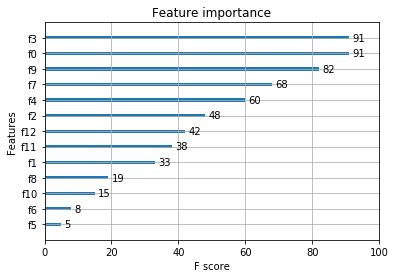

In [19]:
xgboost.plot_importance(pipeline.steps[1][1])

f0=age, f3=restbp, f9=oldpeak <br>

We can tune our model now to achieve better accuracy by using grid search and cross validation.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape the algorithm’s desired behavior. Let’s have a look at the most important ones:
- learning_rate (default=0.1): Boosting learning rate (xgb’s “eta”)
- n_estimators (default=100): Number of boosted trees to fit
- max_depth (default=3): Maximum tree depth for base learners
- objective (default='binary:logistic'): Specify the learning task and the corresponding learning objective or a custom objective function to be used

In below cell, we create our XGBoost pipeline and set up the parameter space.

In [20]:
pipeline_gs = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
parameters = {'classifier__learning_rate': [0.01, 0.03], 'classifier__n_estimators': [50, 200]}

We can search for the best parameters over the specified parameters with GridSearchCV. You can use estimator.get_params().keys() to see the available hyperparameters for search.

In [21]:
clf = GridSearchCV(pipeline_gs, parameters, return_train_score=True)

In [22]:
clf.fit(heart_train.values, target_train.values)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__learning_rate': [0.01, 0.03], 'classifier__n_estimators': [50, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [23]:
print("Best score: %s" % (clf.best_score_))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 0.772727272727
Best parameter set: {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 200}


We can see the accuracy of the best parameter combination on test set.

In [24]:
y_pred = clf.predict(heart_test.values)

accuracy_opt = accuracy_score(target_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy_opt * 100.0))

Accuracy: 80.81%


In [25]:
print("Improvement: %.2f%%" % ((accuracy_opt-accuracy)/accuracy*100))

Improvement: 2.56%


<a id="persistence"></a>
## 4. Persist the model

In this section store the XGBoost model in the Watson Machine Learning repository by using Watson Machine Learning repository service Python client libraries.

In [26]:
from repository.mlrepository import MetaNames
from repository.mlrepository import MetaProps
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

Authenticate to Watson Machine Learning service on the IBM Cloud. 



**Action**: Put authentication information from your instance of Watson Machine Learning service in the following cell.  
<br>
**Tip**: service_path, user and password can be found on the **Service Credentials** tab of the service instance created in IBM Cloud.<br>
To view the instance go to <a href="https://dataplatform.ibm.com/data/services?target=watson&context=analytics">Watson Services</a> (Services > Watson Services).<br>
Click on the vertical ellipse on the right hand side and then select <b>Manage in IBM Cloud</b> for the Watson Machine Learning service.<br>
Select <b>Service Credentials</b> and then 
<br>Generate new credentials by pressing **New credential (+)** button. 
<br>Then <b>View credentials</b><br>
Cut and paste credentials below. 

In [27]:
# Need to insert credentials obtained from above steps
wml_credentials = {
  "instance_id": "7082272f-d8fd-44ff-b462-5dee5eda562e",
  "password": "93bbfe5e-f722-4234-866a-0bcb89d2a4d5",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "9f2059ae-0469-437c-b281-c786722ddc56"
}
  


In [28]:
ml_repository_client = MLRepositoryClient(wml_credentials['url'])
ml_repository_client.authorize(wml_credentials['username'], wml_credentials['password'])

### 4.1: Save a XGBoost model in the Machine Learning Repository

In this subsection you will learn how to save a model artifact to your Watson Machine Learning instance by using the Watson Machine Learing repository Python client package.

Create an artifact and save it to the machine learning repository by running the following cells:

In [29]:
# Check if props is mandatory
props1 = MetaProps({MetaNames.AUTHOR_NAME:"YOUR_name", MetaNames.AUTHOR_EMAIL:"Your_email@email.com"})

model_artifact = MLRepositoryArtifact(clf, name='XGB_Heart_Disease_Detection', meta_props=props1)

saved_model = ml_repository_client.models.save(model_artifact)


In [30]:
saved_model_meta = saved_model.meta.get()
pprint.pprint(saved_model_meta)

{'authorEmail': None,
 'authorName': 'YOUR_name',
 'creationTime': datetime.datetime(2019, 3, 27, 16, 18, 50, 139000, tzinfo=tzlocal()),
 'lastUpdated': datetime.datetime(2019, 3, 27, 16, 18, 51, 259000, tzinfo=tzlocal()),
 'modelType': 'scikit-model-0.19',
 'modelVersionHref': 'https://us-south.ml.cloud.ibm.com/v2/artifacts/models/105042a2-436e-49fa-a791-e2b734ac309a/versions/7dbe5368-8ad2-4504-9544-f3a92805d4e0',
 'pipelineVersionHref': None,
 'runtime': 'python-3.5',
 'trainingDataRef': {},
 'version': '7dbe5368-8ad2-4504-9544-f3a92805d4e0'}


### 4.2 Load the Booster from the saved model

In [31]:
saved_model_meta['modelVersionHref']

'https://us-south.ml.cloud.ibm.com/v2/artifacts/models/105042a2-436e-49fa-a791-e2b734ac309a/versions/7dbe5368-8ad2-4504-9544-f3a92805d4e0'

In [32]:
loaded_artifact = ml_repository_client.models.version_from_href(saved_model_meta['modelVersionHref'])
loaded_xgb_model = loaded_artifact.model_instance()
print("Type of model: " + str(type(loaded_xgb_model)))

Type of model: <class 'sklearn.model_selection._search.GridSearchCV'>


In [33]:
y_lpredict = loaded_xgb_model.predict(heart_test)
print(y_lpredict)

[0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0
 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1
 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1]


<a id="deploy"></a>
## 5. Deploy to the Cloud

To access the Watson Machine Learning REST APIs we require a Watson Machine Learning access token. 

To create the WML access token, run the commands in the following cell:

In [34]:
import urllib3, requests, json

#headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(wml_credentials['username'], wml_credentials['password']))
headers = urllib3.util.make_headers(basic_auth='{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}


### 5.1: Deploy the model and create online scoring endpoint

Get the `published_models` URL from instance details.

In [35]:
endpoint_instance = wml_credentials['url'] + "/v3/wml_instances/" + wml_credentials['instance_id']
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken} 

response_get_instance = requests.get(endpoint_instance, headers=header)
print(response_get_instance)
#print(response_get_instance.text)

<Response [200]>


In [36]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')
print(endpoint_published_models)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/7082272f-d8fd-44ff-b462-5dee5eda562e/published_models


Execute the following sample code that uses the `published_models` endpoint to get the deployments URL.

Get the list of published models.

In [37]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

response_get = requests.get(endpoint_published_models, headers=header)
print(response_get)
#print(response_get.text)

<Response [200]>


Get published model deployment URL.

In [38]:
[endpoint_deployments] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_get.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]

print(endpoint_deployments)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/7082272f-d8fd-44ff-b462-5dee5eda562e/published_models/105042a2-436e-49fa-a791-e2b734ac309a/deployments


#### 5.1.2 Deploy Model

We can now create the online deployment for the published model.

In [39]:
payload_online = {"name": "xgb_heart_disease_v1", "description": "xgb_heart_disease", "type": "online"}
response_online = requests.post(endpoint_deployments, json=payload_online, headers=header)

print(response_online.text)

{
  "metadata": {
    "guid": "b00b3091-0152-4813-b19d-68f7a62c88a6",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/7082272f-d8fd-44ff-b462-5dee5eda562e/published_models/105042a2-436e-49fa-a791-e2b734ac309a/deployments/b00b3091-0152-4813-b19d-68f7a62c88a6",
    "created_at": "2019-03-27T16:26:28.641Z",
    "modified_at": "2019-03-27T16:26:31.860Z"
  },
  "entity": {
    "runtime_environment": "python-3.5",
    "name": "xgb_heart_disease_v1",
    "scoring_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/7082272f-d8fd-44ff-b462-5dee5eda562e/published_models/105042a2-436e-49fa-a791-e2b734ac309a/deployments/b00b3091-0152-4813-b19d-68f7a62c88a6/online",
    "deployable_asset": {
      "name": "XGB_Heart_Disease_Detection",
      "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/7082272f-d8fd-44ff-b462-5dee5eda562e/published_models/105042a2-436e-49fa-a791-e2b734ac309a",
      "guid": "105042a2-436e-49fa-a791-e2b734ac309a",
      "created_at": "2019-03-27T16

In [40]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/7082272f-d8fd-44ff-b462-5dee5eda562e/published_models/105042a2-436e-49fa-a791-e2b734ac309a/deployments/b00b3091-0152-4813-b19d-68f7a62c88a6/online


<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! You learned how to use XGBoost machine learning as well as Watson Machine Learning for model creation and deployment. Check out our [Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/pm_service_api_spark.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Original Author

**Krishnamurthy Arthanarisamy**, is a senior technical lead in IBM Watson Machine Learning team. Krishna works on developing cloud services that caters to different stages of machine learning and deep learning modeling life cycle. 

### Additional Authors - have modified the Notebook for use in the Proof of Technology
**Bernie Beekman ** is an Executive I/T Architect in IBM's Federal Analytical Solution Center <br>
**Joel Patterson ** is on the Federal Big Data Engineering team. 

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.